# Análisis de Circuitos: Resolución ejercicio TP7.2.2

In [1]:
from sympy import plot as splot, Function, Symbol, Eq, I, latex, Mul, \
                  conjugate as conj, UnevaluatedExpr as Ue, arg, ln, \
                  sympify, pi, sqrt, Piecewise
from sympy.plotting import PlotGrid
from matplotlib import pyplot as plt
from sympy.abc import s
from typeguard import typechecked
from utils import splot_multiple as smplot, partition, log10, dB, xlog, \
                  change_figure_size, spike_train
from bode import Rational, Zero, split_conjugates, real_negative_nth, \
                 complex_conjugate_simple_pole
from functools import partial, reduce
from IPython.display import display, Markdown as Md
PlotGrid2V = lambda g1, g2: PlotGrid(2, 1, g1, g2)
smplot = partial(typechecked(smplot), plotf=splot)
change_figure_size = partial(change_figure_size, pyplot=plt)
vertical = lambda var, x0: (var-x0)*9999999999

## Problemática
Dada una función operacional se pide realizar las gráficas de Bode correspondientes.

### Datos

In [2]:
H = Function("H")
w = Symbol("omega", real=True, positive=True)
sdB = Function("dB")
rango_log_freq = (0.01, 1000)
tf = Rational.from_dict(
    {sympify(k): v for k, v in {0: 2, -1: -2, -10-30*I: -1, -10+30*I: -1}.items()}, 900)
Eq(H(s), tf.as_rational(s))

Eq(H(s), 900*s**2/((s + 1)**2*(s + 10 - 30*I)*(s + 10 + 30*I)))

## Resolución

La teoría del Diagrama de Bode propone expresar la ganancia y el cambio de fase del sistema a estado permanente utilizando gráficas logarítmicas en el eje de las abscisas para ambos casos, y para las ordenadas de la ganancia. 

Teniendo en cuenta que los productos y las potencias en el espacio lineal se mapean a sumas y productos en el espacio logarítmico de la amplitud y en el espacio de la fase, y que gran parte de las funciones de transferencia propuestas están compuestas por éstas operaciones, no resulta difícil llegar a la conclusión de que las gráficas a resolver no serán más que la superposición de los productos que componen a la función de transferencia del sistema.

### Identificando las raíces, los ceros y el factor de escala $H_0$

A simple vista se puede observar que $H(s)$ presenta un coeficiente constante $H_0=900$, un cero doble en $0$, un polo doble en $-1$ y un polo simple conjugado en $-10{\pm}30i$, así $H(s)$ puede reescribirse de la siguiente forma:

In [3]:
polos_conjugados, polos_y_ceros = split_conjugates(tf.zeros, -1)
polos_conjugados_expr = [
    (s - polo_conj)**orden*(s - conj(polo_conj))**orden \
        for polo_conj, orden in polos_conjugados.items()]
ceros, polos = map(list, partition(
    lambda cero: Zero(*cero).order < 0, polos_y_ceros.items()))
polos_y_ceros_expr = [(s - punto)**orden for punto, orden in polos_y_ceros.items()]
H_n_s = [tf.scale] + polos_y_ceros_expr + polos_conjugados_expr
display(Eq(H(s), Mul(*map(Ue, H_n_s))))
display(Md("Para el estado permanente ($H := H({\omega}i)$):"))
H_n_w = list(map(lambda expr: sympify(expr).subs(s, I*w), H_n_s))
display(Eq(H(w), Mul(*map(Ue, H_n_w))))
display(Eq(H(w), Mul(*(Function(f"H_{i+1}")(w) for i, _ in enumerate(H_n_s)))))

Eq(H(s), 900*s**2*(s + 1)**(-2)*(1/((s + 10 - 30*I)*(s + 10 + 30*I))))

Para el estado permanente ($H := H({\omega}i)$):

Eq(H(omega), 900*(-omega**2)*(I*omega + 1)**(-2)*(1/((I*omega + 10 - 30*I)*(I*omega + 10 + 30*I))))

Eq(H(omega), H_1(omega)*H_2(omega)*H_3(omega)*H_4(omega))

Listando cada producto:

In [4]:
for i, expr in enumerate(H_n_w):
   display(Eq(Function(f"H_{i+1}")(w), expr))

Eq(H_1(omega), 900)

Eq(H_2(omega), -omega**2)

Eq(H_3(omega), (I*omega + 1)**(-2))

Eq(H_4(omega), 1/((I*omega + 10 - 30*I)*(I*omega + 10 + 30*I)))

#### Término constante ($H_1$)

Para constantes reales positivas la fase es $0°$, y la magnitud corresponde a su mismo valor

In [5]:
display(Eq(sdB(abs(Function("H_1")(w))), dB(abs(H_n_w[0]))))
display(Eq(arg(Function("H_1")(w)), arg(H_n_w[0])))

Eq(dB(Abs(H_1(omega))), 20*log(9)/log(10) + 40)

Eq(arg(H_1(omega)), 0)

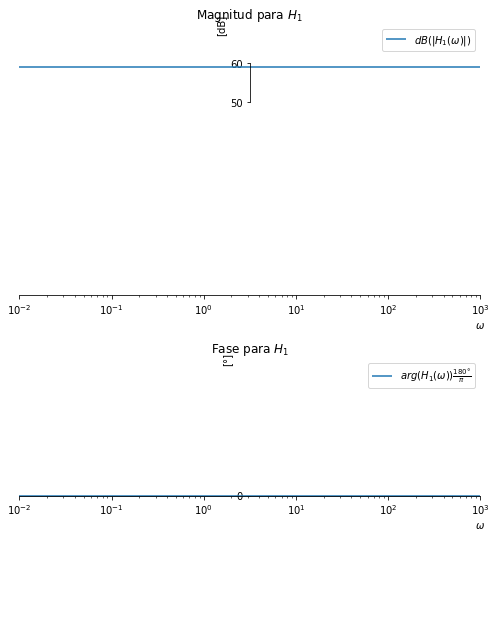

In [6]:
with change_figure_size(7, 9):
    PlotGrid2V(
    smplot((dB(abs(H_n_w[0])), dict(label=r"$dB(|H_1(\omega)|)$")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[dB]", ylim=(-1, 70), xscale="log",
           xlabel=r"$\omega$", title="Magnitud para $H_1$", show=False),
    smplot((arg(H_n_w[0])*180/pi, 
               dict(label=r"$arg(H_1(\omega))\frac{180°}{\pi}$")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[°]", ylim=(-180, 180), xscale="log",
           xlabel=r"$\omega$", title="Fase para $H_1$", show=False)
    )

#### Cero doble en el origen ($H_2$)

Para los ceros de orden $n$, al aplicarle la función valor absoluto y logaritmo, el exponente puede migrar desde el argumento a ser producto de la expresión final en $\textrm{dB}$ de la siguiente manera:
$$H({\omega})=\pm {\omega}^n$$
$$\textrm{dB}(|H({\omega})|)=20log(|\pm{\omega}^n|)=\underbrace{n20}_{m}\cdot\underbrace{log(\omega)}_{x}\quad\forall\omega\ge 0\land n\in\mathbb{R}$$
Así, si el eje independiente está expresado de forma logarítmica ($x=log(\omega)$), la curva puede asociarse a una recta que intersecta al origen de pendiente $m=n20$ con la ecuación $y=m\cdot x$ en el plano a graficar.

Por otro lado, la fase será $0$ o $\pi$ en función del signo que acompañe al cero.

En éste caso, las expresiones se resuelven a:

In [7]:
display(Eq(sdB(abs(Function("H_2")(w))), dB(abs(H_n_w[1])).simplify()))
display(Eq(arg(Function("H_2")(w)), arg(H_n_w[1]).simplify()))

Eq(dB(Abs(H_2(omega))), 40*log(omega)/log(10))

Eq(arg(H_2(omega)), pi)

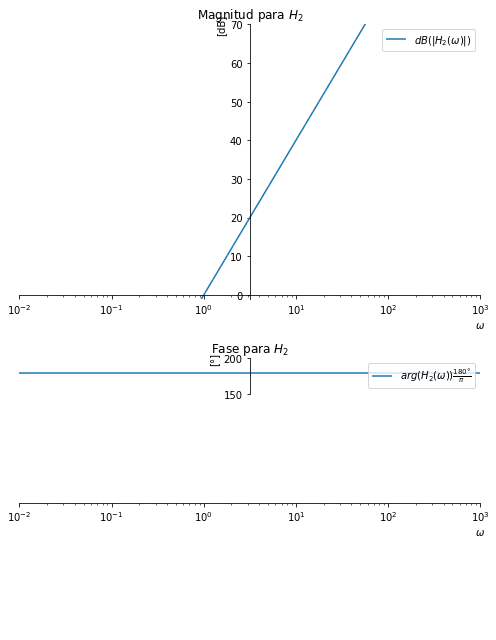

In [8]:
with change_figure_size(7, 9):
    PlotGrid2V(
    smplot((dB(abs(H_n_w[1])), dict(label=r"$dB(|H_2(\omega)|)$")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[dB]", ylim=(-1, 70), xscale="log",
           xlabel=r"$\omega$", title="Magnitud para $H_2$", show=False),
    smplot((arg(H_n_w[1])*180/pi,
               dict(label=r"$arg(H_2(\omega))\frac{180°}{\pi}$")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[°]", ylim=(-180, 200), xscale="log",
           xlabel=r"$\omega$", title="Fase para $H_2$", show=False)
    )

#### Polo doble real menor que cero ($H_3$)

Un polo enésimo expresado de la siguiente forma generaliza al tercer término de la función de transferencia $H(\omega)$
$$H(\omega)=\frac{1}{(i\omega + a)^n}\quad a\in\mathbb{R^+}$$

##### Cálculo de la amplitud
Aplicando el módulo y el logaritmo a ambos lados de la igualdad, y teniendo en cuenta que $|z^n|=|z|^n$ se cumple $\forall n\in\mathbb{R} \land\forall z\in\mathbb{C}$ entonces la expresión puede reescribirse cómo
$$\log(|H(\omega)|)=\log\left(\left|\frac{1}{(i\omega + a)^n}\right|\right)=-n\cdot \log(|i\omega + a|)\quad n\in\mathbb{R}$$
$$\log(|H(\omega)|)=-n/2\cdot \log(\omega^2 + a^2)=-n/2\cdot \left(\log\left(\frac{\omega^2}{a^2} + 1\right)+\log(a^2)\right)$$

Es aquí donde divergemos de los dos análisis anteriores por lo que la expresión conseguida no resulta lineal en el plano logarítmico, para lograr estimar la forma de la curva $\log(|H(\omega)|)$ debemos considerar casos límites para los cuales la expresión se vuelva lineal.

Consideremos el caso para $\omega\to\infty$. Dado que $\omega^2/a^2\gg 1$:
$$\log(|H(\omega)|)\rvert_{\omega\to\infty}=-n/2(\log(\omega^2/a^2)+\log(a^2))=-n\log(\omega)$$
Lo cual puede interpretarse como, que para frecuencias lo suficientemente altas, ésta parte del sistema tenderá a atenuar la señal de forma lineal en el plano logarítmico.

Ahora para otro caso límite, donde $\omega\to 0$
$$\log(|H(\omega)|)\rvert_{\omega\to 0}=-n/2\cdot (\log(1)+2\log(a))=-n\log(a)$$
Entonces para valores lo suficientemente pequeños de $\omega$, la ganancia producto de ésta parte del sistema será constante.

Ambas aproximaciones asintóticas toman la forma de rectas no paralelas en el plano logarítmico, lo que da lugar a una intersección entre ellas, el punto de intersección puede hallarse resolviendo la siguiente igualdad
$$\log(|H(\omega)|)\rvert_{\omega\to\infty}=\log(|H(\omega)|)\rvert_{\omega\to 0}$$
$$-n\log(\omega)=-n\log(a)\implies\omega=a$$

$a$, también llamado frecuencia de corte, ${\omega}_c$ indica el punto de corte entre las aproximaciones asintóticas, el púnto de inflexión dónde el producto pasa de afectar a la señal con ganancia contante, a atenuarla cada vez más a medida que aumenta la frecuencia.

La aproximación final puede escribirse ahora cómo una función por partes
$$
\log(|H(\omega)|) \approx \begin{cases} 
   -n\log(a) & \omega\le a \\
   -n\log(\omega) & \omega\gt a 
\end{cases}
$$

##### Cálculo de la fase

Analizando la expresión $H(\omega)$ ahora para la fase:
$$\arg(H(\omega))=\arg\left(\frac{1}{(i\omega+a)^n}\right)$$
$$\arg(H(\omega))=-\arg((i\omega+a)^n)=-n\cdot \arg(i\omega+a)=-n\cdot \arctan(\omega/a)\quad\forall n\in[0,2]$$

La restricción sobre el dominio de $n$ se debe a que si $i\omega+a$ se encuentra en el primer cuadrante trigonométrico, para $n\gt2$, $(i\omega+a)^n$ podrá ser múltiplo de $-1$, resultando en ángulos erróneos ya que $\arctan(0/-1)=0\ne \arg(-1)$

Nuevamente nos encontramos con una función no lineal, por lo que procedemos a calcular las asíntotas en puntos de interés, empezando por $\omega\to 0$:
$$\arg(H(\omega))\rvert_{\omega\to 0}=-n\cdot \arctan(0)=0$$
y para $\omega\to\infty$:
$$\arg(H(\omega))\rvert_{\omega\to\infty}=-n\cdot \arctan(\infty)=-n\cdot\pi/2$$

Como vemos, las asíntotas encontradas son rectas horizontales con diferentes ordenadas al origen, por lo que no existe intersección entre ellas, para lograr componer una función lineal por partes tendremos que analizar un poco más el comportamiento de la fase.

Por ángulos complementarios, la función $atan$ puede ser expresada en función de la inversa de su argumento de la siguiente forma:
$$\arctan(y/x)=\pi/2-\arctan(x/y)$$
para el caso bajo análisis:
$$\arctan(\omega/a)=\pi/2-\arctan(a/\omega)$$
que puede ser reescrito a:
$$\arctan(10^{\log(\omega)-\log(a)})=\pi/2-\arctan(10^{\log(a)-\log(\omega)})$$
sustituyendo $\log(\omega)$ por el eje de las abcisas en el gráfico:
$$\arctan(10^{x-\log(a)})=\pi/2-\arctan(10^{\log(a)-x})$$
Introducimos un eje desplazado en $x$ por $-\log(a)$ llamdo $u$ ($u=x-\log(a)$), reemplazando:
$$\arctan(10^{u})=\pi/2-\arctan(10^{-u})$$
si a ambos lados se resta $\pi/4$
$$\underbrace{\arctan(10^{u})-\pi/4}_{f(x)}=\underbrace{-(\arctan(10^{-u})-\pi/4)}_{-f(-x)}$$
Ésta demostración nos dice que existe un plano con origen en $[\log(a), \pi/4]$ sobre el plano graficado dónde la fase presenta simetría impar. Aparte de ésto, ya que $u$ es un eje desplazado de $x$, la fase conservará su forma independientemente del valor de $a$ (mas allá de un desplazamiento).

Características de la fase:

1. Presenta un eje de simetría impar desplazada $+\pi/2$ en $w=a$
2. Variaciones en $a$ resultan en desplazamientos de la fase en el gráfico
3. La función de fase deberá ser creciente, ya que la función $atan$ es creciente en todo su dominio, al igual que las funciones exponenciales 

Teniendo un conocimiento un poco más completo sobre la forma de la curva de fase, proseguimos a buscar una forma de remediar las distancias para ambas asíntotas encontradas anteriormente.

La teoría de gráficos de Bode aproxima a la región central de la fase ($x=\log(a)$) mediante una recta con pendiente positiva que intersecta a las dos asíntotas horizontales en $x=\log(a)-1$ y $x=\log(a)+1$, que corresponde a una década antes y después de $a$ en el plano $\omega$. Ésto no deberá sonar extraño en base a las características de la fase, siempre creciente, simétrica en $x=\log(a)$ y los cambios que presenta para cambios de $a$.

La recta para $a/10\lt\omega\le 10 a$ en función de $x$ resulta:
$$\arg(H(\omega))\rvert_{a/10\lt\omega\le 10 a}=(x-\underbrace{\log(a/10)}_{x_0})\frac{\overbrace{-n\cdot\pi/2}^{\Delta y}}{\underbrace{2}_{\Delta x}}$$
y en función de $\omega$:
$$\arg(H(\omega))\rvert_{a/10\lt\omega\le 10 a}=(\log(\omega)-\log(a/10))\frac{-n\cdot\pi/2}{2}$$

Finalmente, la función por partes para baja, media y alta frecuencia puede expresarse como:
$$
\arg(H(\omega))\approx
\begin{cases} 
   0 & \omega\le a/10 \\
   (\log(\omega)-\log(a/10))\frac{-n\cdot\pi/2}{2} & a/10\lt\omega\le 10 a \\
   -n\cdot\pi/2 & 10a\lt\omega
\end{cases}
$$

In [9]:
H_3_approx = real_negative_nth(*(ceros + polos)[1], w)
display(Eq(Function("approx")(sdB(abs(Function("H_3")(w)))),
        dB(H_3_approx[-1][0]*H_3_approx[0]).simplify()))
display(Eq(Function("approx")(arg(Function("H_3")(w))), H_3_approx[-1][1]))

Eq(approx(dB(Abs(H_3(omega)))), Piecewise((0, omega < 1), (-40*log(omega)/log(10), True)))

Eq(approx(arg(H_3(omega))), Piecewise((0, omega < 1/10), (-pi*log(10*omega)/(2*log(10)), omega < 10), (-pi, True)))

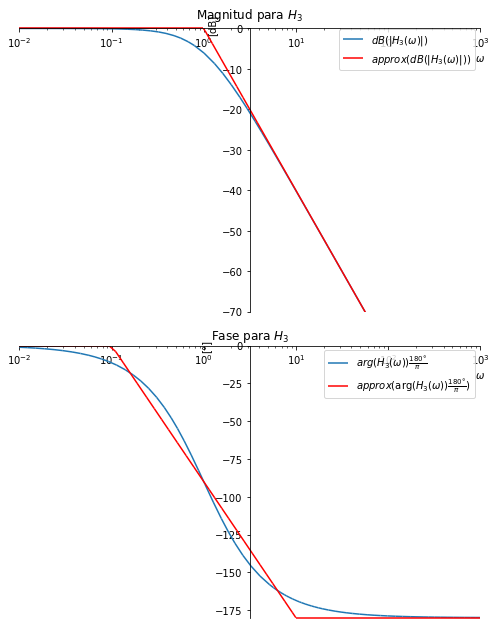

In [10]:
with change_figure_size(7, 9):
    PlotGrid2V(
    smplot((dB(abs(H_n_w[2])), dict(label=r"$dB(|H_3(\omega)|)$")),
           (dB(H_3_approx[-1][0]*H_3_approx[0]), 
               dict(label=r"$approx(dB(|H_3(\omega)|))$", line_color="r")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[dB]", ylim=(-70, 1), xscale="log",
           xlabel=r"$\omega$", title="Magnitud para $H_3$", show=False),
    smplot((arg(H_n_w[2])*180/pi,
               dict(label=r"$arg(H_3(\omega))\frac{180°}{\pi}$")),
           (H_3_approx[-1][1]*180/pi,
               dict(label=r"$approx(\arg(H_3(\omega))\frac{180°}{\pi})$",
                    line_color="r")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[°]", ylim=(-190, 0), xscale="log",
           xlabel=r"$\omega$", title="Fase para $H_3$", show=False)
    )

#### Par de polos conjugados complejos ($H_4$)

El producto bajo análisis puede generalizarse mediante la siguiente expresión

$$H(\omega)=\frac{1}{i\omega+(\alpha+i\beta)}\frac{1}{i\omega+(\alpha-i\beta)}\quad\alpha\lt0\land\beta\neq0$$

Expandiendo la expresión del denominador y normalizando para el término constante:
$$H(\omega)=\frac{1}{-\omega^2+i2\omega\alpha+\alpha^2+\beta^2}=\frac{\frac{1}{\alpha^2+\beta^2}}{-\frac{\omega^2}{\alpha^2+\beta^2}+\frac{i2\omega\alpha}{\alpha^2+\beta^2}+1}$$
a la expresión que divide al término de mayor orden el el denominador se la sustituye por $a^2$ ($a^2=\alpha^2+\beta^2$)
$$H(\omega)=\frac{1/a^2}{-\frac{\omega^2}{a^2}+\frac{i2\omega\alpha}{a^2}+1}$$
al factor del término lineal se lo reemplaza por $\zeta/a$:
$$H(\omega)=\frac{1/a^2}{-\frac{\omega^2}{a^2}+i2\omega\frac\zeta a+1}$$

##### Análisis de magnitud
$$\log(|H(\omega)|)=\log\left(\left|\frac{1/a^2}{-\frac{\omega^2}{a^2}+i2\omega\frac\zeta a+1}\right|\right)=-\log\left(\left|-\frac{\omega^2}{a^2}+i2\omega\frac\zeta a+1\right|\right)-2\log(a)$$
$$\log(|H(\omega)|)=-1/2\cdot \log\left(\left(1-\frac{\omega^2}{a^2}\right)^2+(2\omega\zeta/a)^2\right)-2\log(a)$$

Al igual que para el producto anterior, la expresión de la magnitud resulta lejos de ser lineal, por lo que acudimos a las aproximaciones asintóticas

Para $\omega\to 0$:
$$\log(|H(\omega)|)\rvert_{\omega\to 0}=-1/2\cdot\log(1)-2\log(a)=-2\log(a)$$
y cuando $\omega\to\infty$, dado que $\omega^4\gg\omega^2\gg1$:
$$\log(|H(\omega)|)\rvert_{\omega\to\infty}=\underbrace{-2}_{m}(\underbrace{\log(\omega)}_x-\underbrace{2\log(a)}_{x_0})$$

Dado que ambas asíntotas no son paralelas, existe intersección entre ambas para la condición
$$\log(|H(\omega)|)\rvert_{\omega\to\infty}=\log(|H(\omega)|)\rvert_{\omega\to0}$$
$$-2(\log(\omega)-2\log(a))=-2\log(a)\implies\omega=a$$

La aproximación por partes resulta entonces
$$
\log(|H(\omega)|) \approx \begin{cases} 
   -2\log(a) & \omega\le a \\
   -2(\log(\omega)-2\log(a)) & \omega\gt a 
\end{cases}
$$

Debido a la existencia del parámetro $\zeta$, la función $H$ ahora cuenta con un grado más de libertad aparte de la frecuencia natural del sistema, éste parámetro llamado _factor de amortiguamiento_ describe un método por el cual el sistema puede disipar energía de manera lineal a la respuesta. Un punto crítico de análisis para la influencia de éste parámetro en la teoría de graficas de Bode es en $\omega=\omega_0$, cuándo la frecuencia de excitación coincide con la frecuencia de resonancia del sistema. 

Así, para $\omega\to a$:
$$\log(|H(a)|)=-1/2\cdot \log\left(\left(1-\frac{a^2}{a^2}\right)^2+(2\zeta)^2\right)=-\log(2\zeta)-2\log(a)$$

Para factores de amortiguamiento cercanos a cero, tendremos una respuesta altamente amplificada para valores de $\omega$ muy cercanos a la frecuencia de resonacia, lo que asimismo indica un error mayor en la aproximación, mientras que para valores de $\zeta$ cercanos a $1/2$ el error en $\omega=\omega_0$ será mucho menor.

##### Análisis de fase

$$\arg(H(\omega))=\arg\left(\frac{1/a^2}{-\frac{\omega^2}{a^2}+i2\omega\frac\zeta a+1}\right)=-\arg\left(1-\frac{\omega^2}{a^2}+i2\omega\frac\zeta a\right)$$

Para $\omega\to0$:
$$\arg(H(\omega))\rvert_{\omega\to 0}=-\arg(1-0^2+i0)=0$$
y $\omega\to\infty$:
$$\arg(H(\omega))\rvert_{\omega\to\infty}=-\arg(-\infty^2+i\infty)=-\pi$$

De forma similar al argumento del producto anterior, ambas asíntotas resultan ser paralelas horizontales, por lo que no existe intersección entre ellas, pero por el contrario, la teoría de gráficas de Bode no establece una forma estándar de mediar las distancias utilizando rampas o funciones lineales, simplemente se propone quebrar la aproximación en la frecuencia de corte $\omega_0$. A la izquierda $\omega\to0$ y a la derecha $\omega\to\infty$.

La fase para la frecuencia de corte será entonces:
$$\arg(H(\omega))\rvert_{\omega\to a}=-\arg\left(0+i2\zeta\right)=-\pi/2$$

Así podemos construir una aproximación utilizando tres tramos:
$$
\arg(H(\omega))\approx \begin{cases} 
   0 & \omega\lt a \\
   -\pi/2 & \omega = a \\
   -\pi & \omega\gt a 
\end{cases}
$$
o solamente dos:
$$
\arg(H(\omega))\approx \begin{cases} 
   0 & \omega\le a \\
   -\pi & \omega\gt a 
\end{cases}
$$

In [11]:
H_4_approx = complex_conjugate_simple_pole(
    (ceros + polos + list(polos_conjugados.items()))[2][0], w)
display(Eq(Function("approx")(sdB(abs(Function("H_4")(w)))),
        dB(abs(H_4_approx[-1][0]*H_4_approx[0])).simplify()))
display(Eq(Function("approx")(arg(Function("H_4")(w))), 
        H_4_approx[-1][1].simplify()))
display(Eq(Symbol("zeta"), H_4_approx[1]))

Eq(approx(dB(Abs(H_4(omega)))), Piecewise((-60, omega < 10*sqrt(10)), (-40*log(omega)/log(10), True)))

Eq(approx(arg(H_4(omega))), Piecewise((0, omega < 10*sqrt(10)), (-pi, True)))

Eq(zeta, sqrt(10)/10)

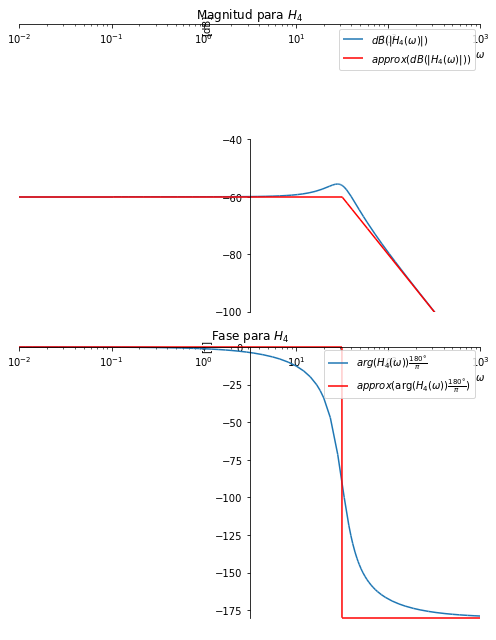

In [12]:
with change_figure_size(7, 9):
    PlotGrid2V(
    smplot((dB(abs(H_n_w[3])), dict(label=r"$dB(|H_4(\omega)|)$")),
           (dB(H_4_approx[-1][0]*H_4_approx[0]), 
               dict(label=r"$approx(dB(|H_4(\omega)|))$", line_color="r")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[dB]", ylim=(-100, 0), xscale="log",
           xlabel=r"$\omega$", title="Magnitud para $H_4$", show=False),
    smplot((arg(H_n_w[3])*180/pi,
               dict(label=r"$arg(H_4(\omega))\frac{180°}{\pi}$")),
           (H_4_approx[-1][1]*180/pi,
               dict(label=r"$approx(\arg(H_4(\omega))\frac{180°}{\pi})$",
                    line_color="r")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[°]", ylim=(-190, 1), xscale="log",
           xlabel=r"$\omega$", title="Fase para $H_4$", show=False)
)

### Combinando los gráficos

En el plano logarítmico, los productos ya calculados $\mathrm{dB}(|H_n(w)|)$ pueden ser sumados para obtener la aproximación total de la respuesta en amplitud del sistema, al igual que con la fase $\arg(H_n(w))$.

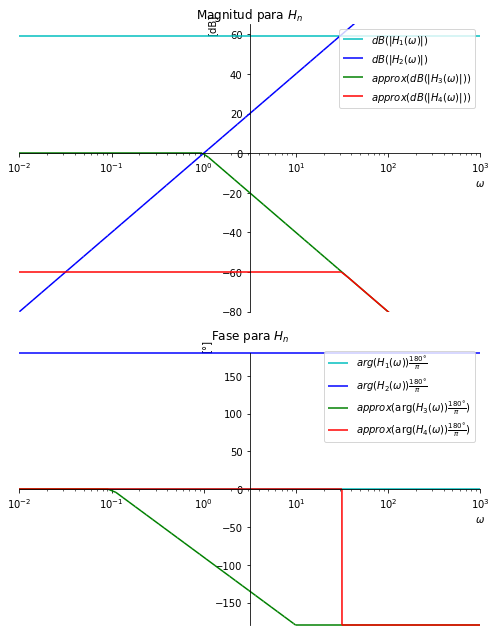

In [13]:
with change_figure_size(7, 9):
    PlotGrid2V(
    smplot((dB(abs(H_n_w[0])),
               dict(label=r"$dB(|H_1(\omega)|)$", line_color="c")),
           (dB(abs(H_n_w[1])), 
               dict(label=r"$dB(|H_2(\omega)|)$", line_color="b")),
           (dB(H_3_approx[-1][0]*H_3_approx[0]), 
               dict(label=r"$approx(dB(|H_3(\omega)|))$", line_color="g")),
           (dB(H_4_approx[-1][0]*H_4_approx[0]), 
               dict(label=r"$approx(dB(|H_4(\omega)|))$", line_color="r")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[dB]", ylim=(-80, 65), xscale="log",
           xlabel=r"$\omega$", title="Magnitud para $H_n$", show=False),
    smplot((arg(H_n_w[0])*180/pi, 
               dict(label=r"$arg(H_1(\omega))\frac{180°}{\pi}$",
                    line_color="c")),
           (arg(H_n_w[1])*180/pi,
               dict(label=r"$arg(H_2(\omega))\frac{180°}{\pi}$",
                    line_color="b")),
           (H_3_approx[-1][1]*180/pi,
               dict(label=r"$approx(\arg(H_3(\omega))\frac{180°}{\pi})$",
                    line_color="g")),
           (H_4_approx[-1][1]*180/pi,
               dict(label=r"$approx(\arg(H_4(\omega))\frac{180°}{\pi})$",
                    line_color="r")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[°]", ylim=(-190, 190), xscale="log",
           xlabel=r"$\omega$", title="Fase para $H_n$", show=False)
    )

In [14]:
H_w_abs_approx = sum([
    dB(abs(H_n_w[0])),
    dB(abs(H_n_w[1])),
    dB(H_3_approx[-1][0]*H_3_approx[0]),
    dB(H_4_approx[-1][0]*H_4_approx[0])
])

H_w_arg_approx = sum([
    arg(H_n_w[0]),
    arg(H_n_w[1]),
    H_3_approx[-1][1],
    H_4_approx[-1][1]
])

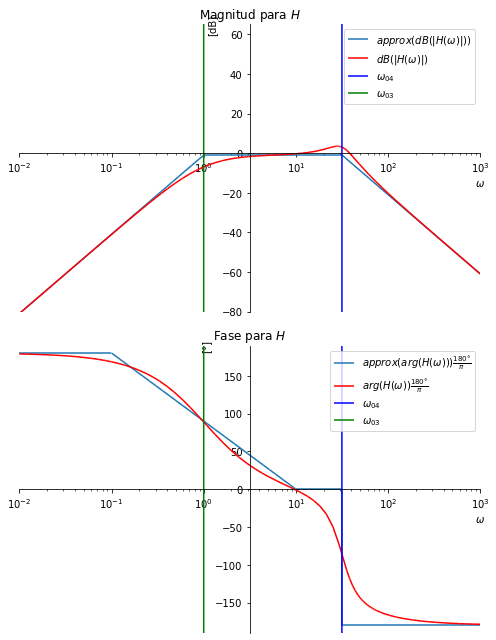

In [15]:
with change_figure_size(7, 9):
    PlotGrid2V(
    smplot((H_w_abs_approx, dict(label=r"$approx(dB(|H(\omega)|))$")),
           (dB(abs(tf.as_rational(w*I))), 
               dict(label=r"$dB(|H(\omega)|)$", line_color="r")),
           (vertical(w, sqrt(1/H_4_approx[0])), 
               dict(label=r"$\omega_{04}$", line_color="b")),
           (vertical(w, sqrt(1/H_3_approx[0])), 
               dict(label=r"$\omega_{03}$", line_color="g")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[dB]", ylim=(-80, 65), xscale="log",
           xlabel=r"$\omega$", title="Magnitud para $H$", show=False),
    smplot((H_w_arg_approx*180/pi,
               dict(label=r"$approx(arg(H(\omega)))\frac{180°}{\pi}$")),
           (arg(tf.as_rational(w*I))*180/pi,
               dict(label=r"$arg(H(\omega))\frac{180°}{\pi}$",
                    line_color="r")),
           (vertical(w, sqrt(1/H_4_approx[0])), 
               dict(label=r"$\omega_{04}$", line_color="b")),
           (vertical(w, sqrt(1/H_3_approx[0])), 
               dict(label=r"$\omega_{03}$", line_color="g")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[°]", ylim=(-190, 190), xscale="log",
           xlabel=r"$\omega$", title="Fase para $H$", show=False)
    )

### Mejorando la aproximación

Para ciertos puntos críticos donde la diferencia entre la aproximación y la función real son muy grandes agregamos correcciones.

Las correcciones a aplicar solo tienen sentido para $H_3$ y $H_4$, ya que las demas funciones se presentan en su forma completa, sin aproximaciones.

Para $H_3$, sacando los datos de tablas:

In [16]:
H3_abs_fix_table = {
    1/100: 0, 
    1/10:  -.04, 
    1/2:   -1, 
    1:     -3,
    2:     -1,
    10:    -.04, 
    100:   0
}
H3_abs_fix = spike_train(w/sqrt(1/H_3_approx[0]), H3_abs_fix_table)
display(Eq(Symbol(" +abs(|H_{3}|)"), Piecewise(
    *((y, Eq(w/Symbol("omega_03"), x)) for x, y in H3_abs_fix_table.items()))))

H3_arg_fix_table = {
    1/100: 0,
    1/10:  -5.7,
    1/2:   4.9,
    1:     1,
    2:     -4.9,
    10:    5.7,
    100:   0
}
H3_arg_fix = spike_train(w/sqrt(1/H_3_approx[0]), H3_abs_fix_table)
display(Eq(Symbol(" +arg(H_{3})"), Piecewise(
    *((y, Eq(w/Symbol("omega_03"), x)) for x, y in H3_arg_fix_table.items()))))

Eq( +abs(|H_{3}|), Piecewise((0, Eq(omega/omega_03, 0.01)), (-0.04, Eq(omega/omega_03, 0.1)), (-1, Eq(omega/omega_03, 0.5)), (-3, Eq(omega/omega_03, 1)), (-1, Eq(omega/omega_03, 2)), (-0.04, Eq(omega/omega_03, 10)), (0, Eq(omega/omega_03, 100))))

Eq( +arg(H_{3}), Piecewise((0, Eq(omega/omega_03, 0.01)), (-5.7, Eq(omega/omega_03, 0.1)), (4.9, Eq(omega/omega_03, 0.5)), (1, Eq(omega/omega_03, 1)), (-4.9, Eq(omega/omega_03, 2)), (5.7, Eq(omega/omega_03, 10)), (0, Eq(omega/omega_03, 100))))

Para $H_4$, las tablas de corrección incluyen el parámetro $\zeta$ debido a que éste cambia la forma de la curva, y por ende los errores.

In [17]:
H4_abs_fix_table = {
    1/10:  0, 
    1/2:   1.8, 
    1:     4.4,
    2:     1.8,
    10:    0,
}
H4_abs_fix = spike_train(w/sqrt(1/H_4_approx[0]), H4_abs_fix_table)
display(Eq(Symbol(" +abs(|H_{4}|)"), Piecewise(
    *((y, Eq(w/Symbol("omega_04"), x)) for x, y in H4_abs_fix_table.items()))))

H4_arg_fix_table = {
    1/10:  0, 
    1/2:   -21.8,
    1:     0,
    2:     21.8,
    10:    0,
}
H4_arg_fix = spike_train(log10(w/sqrt(1/H_4_approx[0])), 
    {log10(k): v for k, v in H4_abs_fix_table.items()})
display(Eq(Symbol(" +arg(H_{4})"), Piecewise(
    *((y, Eq(w/Symbol("omega_04"), x)) for x, y in H4_arg_fix_table.items()))))

Eq( +abs(|H_{4}|), Piecewise((0, Eq(omega/omega_04, 0.1)), (1.8, Eq(omega/omega_04, 0.5)), (4.4, Eq(omega/omega_04, 1)), (1.8, Eq(omega/omega_04, 2)), (0, Eq(omega/omega_04, 10))))

Eq( +arg(H_{4}), Piecewise((0, Eq(omega/omega_04, 0.1)), (-21.8, Eq(omega/omega_04, 0.5)), (0, Eq(omega/omega_04, 1)), (21.8, Eq(omega/omega_04, 2)), (0, Eq(omega/omega_04, 10))))

Se presenta a continuación el gráfico de bode final, con las correcciones realizadas:

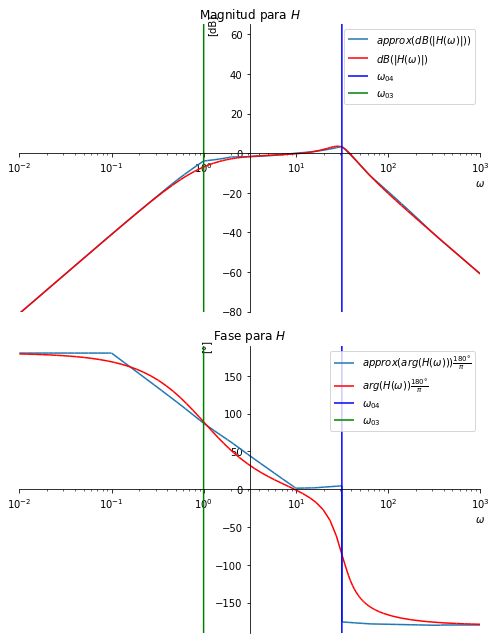

In [19]:
with change_figure_size(7, 9):
    PlotGrid2V(
    smplot((H_w_abs_approx + H4_abs_fix + H3_abs_fix, 
               dict(label=r"$approx(dB(|H(\omega)|))$")),
           (dB(abs(tf.as_rational(w*I))), 
               dict(label=r"$dB(|H(\omega)|)$", line_color="r")),
           (vertical(w, sqrt(1/H_4_approx[0])), 
               dict(label=r"$\omega_{04}$", line_color="b")),
           (vertical(w, sqrt(1/H_3_approx[0])), 
               dict(label=r"$\omega_{03}$", line_color="g")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[dB]", ylim=(-80, 65), xscale="log",
           xlabel=r"$\omega$", title="Magnitud para $H$", show=False),
    smplot((H_w_arg_approx*180/pi + H3_arg_fix + H4_arg_fix,
               dict(label=r"$approx(arg(H(\omega)))\frac{180°}{\pi}$")),
           (arg(tf.as_rational(w*I))*180/pi,
               dict(label=r"$arg(H(\omega))\frac{180°}{\pi}$",
                    line_color="r")),
           (vertical(w, sqrt(1/H_4_approx[0])), 
               dict(label=r"$\omega_{04}$", line_color="b")),
           (vertical(w, sqrt(1/H_3_approx[0])), 
               dict(label=r"$\omega_{03}$", line_color="g")),
           ((w,) + rango_log_freq, None),
           legend=True, ylabel="[°]", ylim=(-190, 190), xscale="log",
           xlabel=r"$\omega$", title="Fase para $H$", show=False)
    )